# CNN on CIFAR-10 Dataset

This project will involve predicting the label of a picture by feeding in the picture to a CNN architecture. The dataset used is the CIFAR-10 dataset. The CNN architecture will be defined, trained, and the learnt filters visualised.

CIFAR-10 dataset (found here: https://www.cs.toronto.edu/~kriz/cifar.html) contains 32x32 color images from 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck:
<img src="images/cifar10.jpg" style="width:80%">

This project has been adapted from Coursera's Advanced Machine Learning course

In [1]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

Using TensorFlow backend.


2.0.0
2.3.1


In [2]:
#utility functions

from collections import defaultdict
import numpy as np
from keras.models import save_model
import tensorflow as tf
import keras
from keras import backend as K

class TqdmProgressCallback(keras.callbacks.Callback):

    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']

    def on_epoch_begin(self, epoch, logs=None):
        print('\nEpoch %d/%d' % (epoch + 1, self.epochs))
        if "steps" in self.params:
            self.use_steps = True
            self.target = self.params['steps']
        else:
            self.use_steps = False
            self.target = self.params['samples']
        self.prog_bar = tqdm_notebook_failsafe(total=self.target)
        self.log_values_by_metric = defaultdict(list)

    def _set_prog_bar_desc(self, logs):
        for k in self.params['metrics']:
            if k in logs:
                self.log_values_by_metric[k].append(logs[k])
        desc = "; ".join("{0}: {1:.4f}".format(k, np.mean(values)) for k, values in self.log_values_by_metric.items())
        if hasattr(self.prog_bar, "set_description_str"):  # for new tqdm versions
            self.prog_bar.set_description_str(desc)
        else:
            self.prog_bar.set_description(desc)

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        if self.use_steps:
            self.prog_bar.update(1)
        else:
            batch_size = logs.get('size', 0)
            self.prog_bar.update(batch_size)
        self._set_prog_bar_desc(logs)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self._set_prog_bar_desc(logs)
        self.prog_bar.update(1)  # workaround to show description
        self.prog_bar.close()


class ModelSaveCallback(keras.callbacks.Callback):

    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))
        

In [3]:
from __future__ import print_function
import tqdm
tqdm.monitor_interval = 0  #workaround for https://github.com/tqdm/tqdm/issues/481

class SimpleTqdm():
    def __init__(self, iterable=None, total=None, **kwargs):
        self.iterable = list(iterable) if iterable is not None else None
        self.total = len(self.iterable) if self.iterable is not None else total
        assert self.iterable is not None or self.total is not None
        self.current_step = 0
        self.print_frequency = max(self.total // 50, 1)
        self.desc = ""

    def set_description_str(self, desc):
        self.desc = desc

    def set_description(self, desc):
        self.desc = desc

    def update(self, steps):
        last_print_step = (self.current_step // self.print_frequency) * self.print_frequency
        i = 1
        while last_print_step + i * self.print_frequency <= self.current_step + steps:
            print("*", end='')
            i += 1
        self.current_step += steps

    def close(self):
        print("\n" + self.desc)

    def __iter__(self):
        assert self.iterable is not None
        self.index = 0
        return self

    def __next__(self):
        if self.index < self.total:
            element = self.iterable[self.index]
            self.update(1)
            self.index += 1
            return element
        else:
            self.close()
            raise StopIteration


def use_simple_tqdm():
    try:
        import google.colab
        import os
        return not bool(int(os.environ.get("EXPERIMENTAL_TQDM", "0")))
    except ImportError:
        return False


def tqdm_notebook_failsafe(*args, **kwargs):
    if use_simple_tqdm():
        # tqdm is broken on Google Colab
        return SimpleTqdm(*args, **kwargs)
    else:
        return tqdm.tqdm_notebook(*args, **kwargs)


## Load and visualise dataset

In [4]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [5]:
print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

Train samples: (50000, 32, 32, 3) (50000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


In [6]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

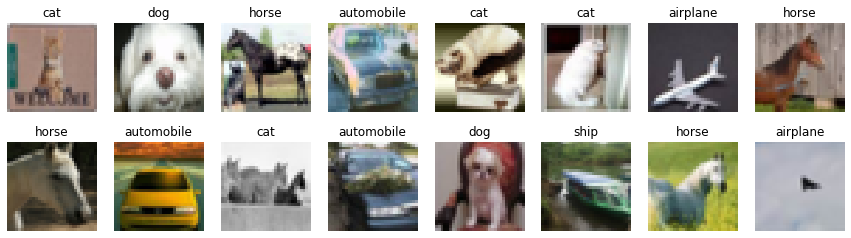

In [7]:
#visualise random images from train set
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

## Data Preparation

Inputs need to be normalised, and class labels need to be converted to one-hot encoded vectors.

In [8]:
#normalise inputs
x_train2 = x_train / 255.0 - 0.5 
x_test2 = x_test / 255.0 - 0.5

#convert class labels to one-hot encoded (labels, num_classes)
y_train2 = keras.utils.to_categorical(y_train, 10) 
y_test2 = keras.utils.to_categorical(y_test, 10)

## Define the CNN architecture

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU

Convolutional networks are built from several types of layers:
- [Conv2D](https://keras.io/layers/convolutional/#conv2d) - performs convolution:
    - **filters**: number of output channels; 
    - **kernel_size**: an integer or tuple/list of 2 integers, specifying the width and height of the 2D convolution window;
    - **padding**: padding="same" adds zero padding to the input, so that the output has the same width and height, padding='valid' performs convolution only in locations where kernel and the input fully overlap;
    - **activation**: "relu", "tanh", etc.
    - **input_shape**: shape of input.
- [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d) - performs 2D max pooling.
- [Flatten](https://keras.io/layers/core/#flatten) - flattens the input, does not affect the batch size.
- [Dense](https://keras.io/layers/core/#dense) - fully-connected layer.
- [Activation](https://keras.io/layers/core/#activation) - applies an activation function.
- [LeakyReLU](https://keras.io/layers/advanced-activations/#leakyrelu) - applies leaky relu activation.
- [Dropout](https://keras.io/layers/core/#dropout) - applies dropout.

A model needs to be defined that takes __(None, 32, 32, 3)__ input and predicts __(None, 10)__ output with probabilities for all classes. __None__ in shapes stands for batch dimension.

Simple feed-forward networks in Keras can be defined in the following way:

```python
model = Sequential()  #start feed-forward model definition
model.add(Conv2D(..., input_shape=(32, 32, 3)))  # first layer defines "input_shape"
# then convolutional, pooling and dropout layers
model.add(Dense(NUM_CLASSES))  #the last layer with neuron for each class
model.add(Activation("softmax"))  #output probabilities
```

In [10]:
#function to define model architecture and return Sequential model
def make_model():
    model = Sequential()

    #stacking 4 convolutional layers with kernel size (3, 3) with growing
    #number of filters (16, 32, 32, 64) using "same" padding
    model.add(Conv2D(16, (3, 3), padding='same', input_shape=(32, 32, 3)))
    
    #LeakyReLU activation with recommended parameter 0.1 for all layers
    #that need it (after convolutional and dense layers)
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(LeakyReLU(0.1))
    
    #2x2 pooling layer after every 2 convolutional layers (conv-conv-pool scheme)
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #Dropout after every pooling layer (0.25)
    model.add(Dropout(0.25))

    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    #Flatten layer before first dense layer to reshape input volume into a flat vector
    model.add(Flatten())
    
    #dense layer with 256 neurons and a second dense layer with 10 neurons for classes
    model.add(Dense(256))
    model.add(LeakyReLU(0.1))
    #Dropout between dense layers (0.5)
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    return model

In [11]:
#describe model
#s = tf.keras.backend.clear_session()  # clear default graph
model = make_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)       

## Train the model

If loss on training is not decreasing with epochs the model definition and learning rate need to be revised.

In [12]:
INIT_LR = 5e-3  #initial learning rate
BATCH_SIZE = 32
EPOCHS = 10

s = tf.keras.backend.clear_session()

#do not call K.set_learning_phase() (otherwise will enable dropout in train/test simultaneously)
model = make_model()  #define model

#prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  #train 10-way classification
    optimizer=keras.optimizers.adamax(lr=INIT_LR),  #for SGD
    metrics=['accuracy']  #report accuracy during training
)

#scheduler of learning rate (decay with epochs)
def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch

#callback for printing of actual learning rate used by optimizer
class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model.optimizer.lr))

Training takes approximately **1.5 hours**. You're aiming for ~0.80 validation accuracy.

In [13]:
# we will save model checkpoints to continue training in case of kernel death
model_filename = 'cifar.{0:03d}.hdf5'
last_finished_epoch = None

#### uncomment below to continue training from model checkpoint
#### fill `last_finished_epoch` with your latest finished epoch
# from keras.models import load_model
# s = tf.keras.backend.clear_session()
# last_finished_epoch = 7
# model = load_model(model_filename.format(last_finished_epoch))

In [14]:
# fit model
model.fit(
    x_train2, y_train2,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), 
               LrHistory(), 
               TqdmProgressCallback(),
               ModelSaveCallback(model_filename)],
    validation_data=(x_test2, y_test2),
    shuffle=True,
    verbose=0,
    initial_epoch=last_finished_epoch or 0
)

Learning rate: 0.005

Epoch 1/10


/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Model saved in cifar.000.hdf5
Learning rate: 0.0045

Epoch 2/10



Model saved in cifar.001.hdf5
Learning rate: 0.00405

Epoch 3/10



Model saved in cifar.002.hdf5
Learning rate: 0.003645

Epoch 4/10



Model saved in cifar.003.hdf5
Learning rate: 0.0032805

Epoch 5/10



Model saved in cifar.004.hdf5
Learning rate: 0.00295245

Epoch 6/10



Model saved in cifar.005.hdf5
Learning rate: 0.002657205

Epoch 7/10



Model saved in cifar.006.hdf5
Learning rate: 0.0023914846

Epoch 8/10



Model saved in cifar.007.hdf5
Learning rate: 0.002152336

Epoch 9/10



Model saved in cifar.008.hdf5
Learning rate: 0.0019371024

Epoch 10/10



Model saved in cifar.009.hdf5


In [15]:
#save weights to file
model.save_weights("weights.h5")

In [16]:
#load weights from file
model.load_weights("weights.h5")

## Evaluate the model

In [17]:
#make test predictions
y_pred_test = model.predict_proba(x_test2)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

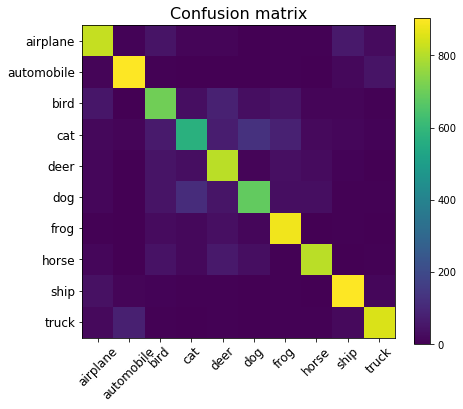

Test accuracy: 0.7948


In [18]:
#confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test, y_pred_test_classes))

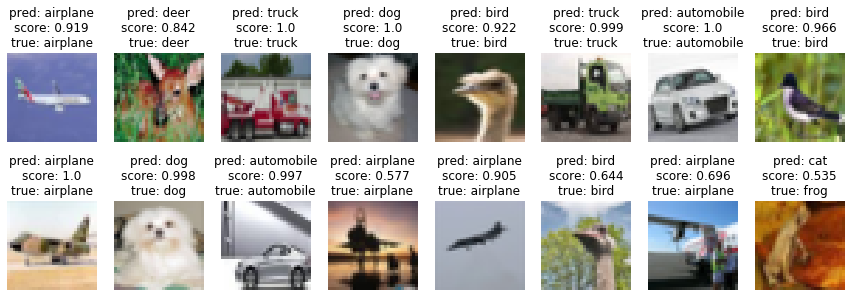

In [19]:
#inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test[random_index, 0]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

From the above examples, it appears that the model has done quite well, although it has varying levels of certainty for its provided labels.

## Visualise maximum stimuli/learnt filters

Find input images that provide maximum activations for particular layers of the network. The maximum stimuli will be found via gradient ascent in image space. For this, model weights are loaded, the layer output gradient is calculated with respect to image input and input image is shifted in that direction.

In [20]:
s = tf.keras.backend.clear_session()  #clear default graph
K.set_learning_phase(0)  #disable dropout
model = make_model()
model.load_weights("weights.h5")

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)       

In [22]:
def find_maximum_stimuli(layer_name, is_conv, filter_index, model, iterations=20, step=1., verbose=True):
    
    def image_values_to_rgb(x):
        # normalise x: centre on 0 (np.mean(x_train2)), ensure std is 0.25 (np.std(x_train2))
        #so it looks like a normalised image input for our network
        x = (x - np.mean(x)) / np.std(x) * 0.25

        #do reverse normalisation to RGB values: x = (x_norm + 0.5) * 255
        x = (x + 0.5) * 255 ### YOUR CODE HERE
    
        #clip values to [0, 255] and convert to bytes
        x = np.clip(x, 0, 255).astype('uint8')
        return x

    #placeholder for input image
    input_img = model.input
    img_width, img_height = input_img.shape.as_list()[1:3]
    
    #find layer output by name
    layer_output = list(filter(lambda x: x.name == layer_name, model.layers))[0].output

    #build a loss function that maximises activation
    #of filter_index filter of layer considered
    if is_conv:
        #mean over feature map values for convolutional layer
        loss = K.mean(layer_output[:, :, :, filter_index])
    else:
        loss = K.mean(layer_output[:, filter_index])

    #compute gradient of loss with respec to input image
    grads = K.gradients(loss, input_img)[0]  #[0] due to batch dimension

    #normalisation trick - normalise the gradient
    grads = grads / (K.sqrt(K.sum(K.square(grads))) + 1e-10)

    #this function returns loss and grads given input picture
    iterate = K.function([input_img], [loss, grads])

    #start from a gray image with some random noise
    input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * (0.1 if is_conv else 0.001)

    #run gradient ascent
    for i in range(iterations):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        if verbose:
            print('Current loss value:', loss_value)

    #decode resulting input image
    img = image_values_to_rgb(input_img_data[0])
    
    return img, loss_value

In [23]:
#sample maximum stimuli
def plot_filters_stimuli(layer_name, is_conv, model, iterations=20, step=1., verbose=False):
    cols = 8
    rows = 2
    filter_index = 0
    max_filter_index = list(filter(lambda x: x.name == layer_name, model.layers))[0].output.shape.as_list()[-1] - 1
    fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
    for i in range(cols):
        for j in range(rows):
            if filter_index <= max_filter_index:
                ax = fig.add_subplot(rows, cols, i * rows + j + 1)
                ax.grid('off')
                ax.axis('off')
                loss = -1e20
                while loss < 0 and filter_index <= max_filter_index:
                    stimuli, loss = find_maximum_stimuli(layer_name, is_conv, filter_index, model,
                                                         iterations, step, verbose=verbose)
                    filter_index += 1
                if loss > 0:
                    ax.imshow(stimuli)
                    ax.set_title("Filter #{}".format(filter_index))
    plt.show()

leaky_re_lu_1


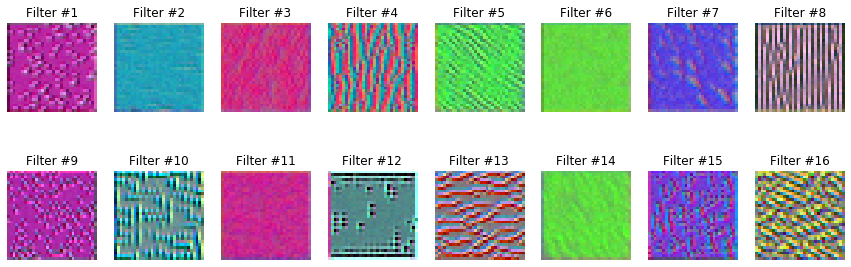

leaky_re_lu_2


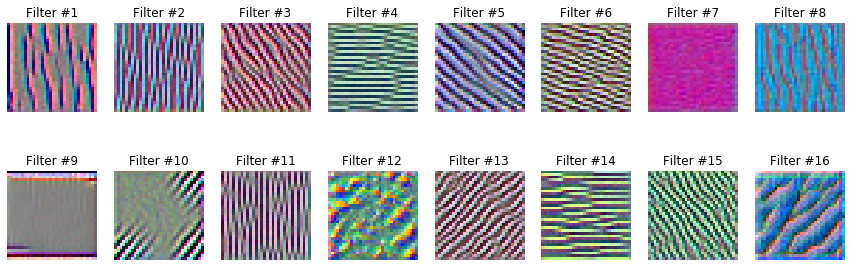

leaky_re_lu_3


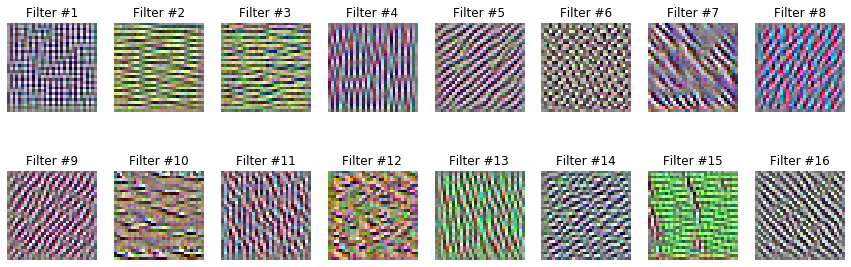

leaky_re_lu_4


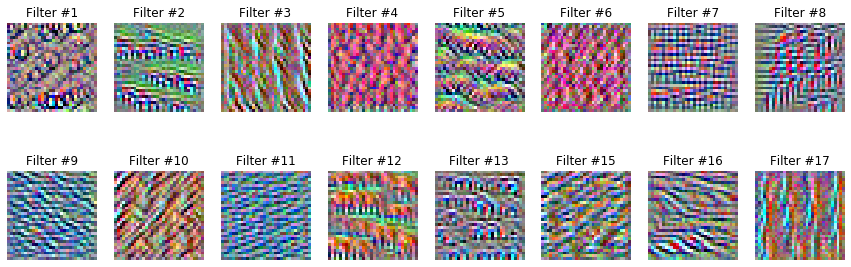

In [24]:
prev_layer = None
#maximum stimuli for convolutional neurons
conv_activation_layers = []
for layer in model.layers:
    if isinstance(layer, LeakyReLU):
        #prev_layer = layer.inbound_nodes[0].inbound_layers[0]
        if isinstance(prev_layer, Conv2D):
            conv_activation_layers.append(layer)
    prev_layer = layer

for layer in conv_activation_layers:
    print(layer.name)
    plot_filters_stimuli(layer_name=layer.name, is_conv=True, model=model)

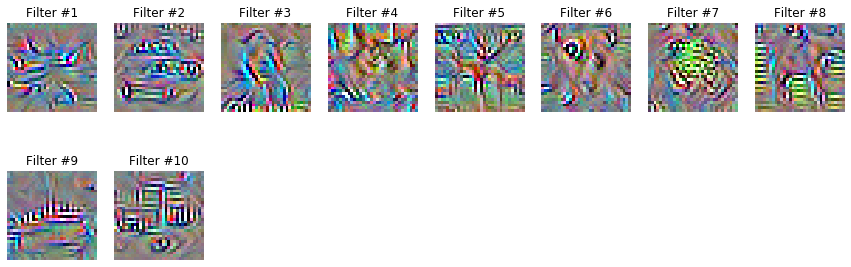

In [25]:
#maximum stimuli for last dense layer
last_dense_layer = list(filter(lambda x: isinstance(x, Dense), model.layers))[-1]
plot_filters_stimuli(layer_name=last_dense_layer.name, is_conv=False, 
                     iterations=200, step=0.1, model=model)